# Introduction
## Outline of the problem
Companies like Amazon and Ebay face the practical problem of matching customers to products. Collaborative filtering algorithms solve this problem by using past behaviors of users to make future recommendations, ignoring any $\textit{a priori}$ information. One method of implementing collaborative filtering is to employ a neighborhood based approach wherein users and objects are embedded into points in $R^d$ and recommendations are made for a given user $i$ based on how the scores of $i$ overlap with the scores of other users.

## Matrix Factorization
Matrix factorization is a way to find the user and object locations in $R^d$. We factorize the matrix of users and objects into two low rank matrices. The following code implements a maximum a posteriori inference co-ordinate ascent algorithm for matrix factorization.

## Data
The dataset being used here is the MovieLens dataset collected by the GroupLens Research Project at the University of Minnesota. It consists of 100,000 ratings from 943 users on 1682 movies. 

In [20]:
%matplotlib notebook
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import math
import random
from __future__ import division
from tqdm import trange
import IPython
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# loading data

In [2]:
ratings = pd.read_csv("/Users/antoshachekhonte/Documents/ML/Homework_4/hw4-data/ratings.csv", header = None)
ratings_test = pd.read_csv("/Users/antoshachekhonte/Documents/ML/Homework_4/hw4-data/ratings_test.csv", header = None)
movies = pd.read_csv("/Users/antoshachekhonte/Documents/ML/Homework_4/hw4-data/movies.txt", delimiter = '\n', header = None)

ratings.columns = ['uid', 'oid', 'rating']
ratings_test.columns = ['uid', 'oid', 'rating']

movies.columns = ['name']

In [3]:
data_train = [k for k in ratings.groupby(['uid', 
                                          'oid'])]
data_users = {}
data_objects = {}

for i in range(len(data_train)):
    data_users[data_train[i][1].uid.values[0]] = []
    data_objects[data_train[i][1].oid.values[0]] = []
    
for i in range(len(data_train)):
    data_users[data_train[i][1].uid.values[0]].append((data_train[i][1].oid.values[0], data_train[i][1].rating.values[0])) 
    data_objects[data_train[i][1].oid.values[0]].append((data_train[i][1].uid.values[0], data_train[i][1].rating.values[0]))

In [ ]:
# class object for co-ordinate ascent

In [4]:
class c_ascent1(object):
    def __init__(self, data_users, data_objects, sigma_sq, d, l):
        
        self.data_users = data_users
        self.data_objects = data_objects
        
        self.n1 = len(self.data_users)
        self.n2 = len(self.data_objects)
        
        self.sigma_sq = sigma_sq
        self.d = d
        self.l = l
        
        self.v = (np.random.normal(0, math.sqrt(self.l), self.d * 1682)).reshape((self.d, 1682))
        self.u = (np.random.normal(0, math.sqrt(self.l), self.d * self.n1)).reshape((self.d, self.n1))
        
        self.loss = []
        self.loss1 = 0
        self.loss2 = 0
        self.loss3 = 0
        
        self.RMSE = 0
        
    def update_u(self):
        
        self.loss2 = 0
        
        for user in self.data_users.keys():
            
            first_term = self.l * self.sigma_sq * np.eye(self.d)
            second_term = np.zeros((self.d, 1))
            
            for obj in self.data_users[user]:
                first_term += np.matmul(self.v[:, obj[0] - 1].reshape((10, 1)), self.v[:, obj[0] - 1].reshape((10, 1)).T)
                second_term += obj[1] * self.v[:, obj[0] - 1].reshape((10, 1))
                
            first_term_inv = np.linalg.inv(first_term)
            
            # Updating u_i
            self.u[:, user - 1] = np.matmul(first_term_inv, second_term).reshape((self.d, ))
            
            # Loss term 2
            self.loss2 -= (self.l / 2) * (np.linalg.norm(self.u[:, user - 1]) ** 2)
            
    def update_v(self):
        
        self.loss3 = 0
        
        for obj in self.data_objects.keys():
            
            first_term = self.l * self.sigma_sq * np.eye(self.d)
            second_term = np.zeros((self.d, 1))
            
            for user in self.data_objects[obj]:
                first_term += np.matmul(self.u[:, user[0] - 1].reshape((10, 1)), self.u[:, user[0] - 1].reshape((10, 1)).T)
                second_term += user[1] * self.u[:, user[0] - 1].reshape((10, 1))
                
            first_term_inv = np.linalg.inv(first_term)
            
            # Updating v_i
            self.v[:, obj - 1] = np.matmul(first_term_inv, second_term).reshape((self.d, ))
            
            # Loss term 3
            self.loss3 -= (self.l / 2) * (np.linalg.norm(self.v[:, obj - 1]) ** 2)
            
    def run(self, iterations):
        
        for r in trange(iterations):
            
            self.loss1 = 0
            
            self.update_u()
            self.update_v()
            
            # Loss term 1
            for user in self.data_users.keys():
                
                for obj in self.data_users[user]:
                    
                    M_ij = obj[1]
                    u_iTv_j = np.matmul(self.u[:, user - 1].T, self.v[:, obj[0] - 1])
                    
                    self.loss1 -= (1 / (2 * self.sigma_sq)) * ((M_ij - u_iTv_j) ** 2)
                    
            # Updating loss
            self.loss.append(self.loss1 + self.loss2 + self.loss3)
            
    def RMSE(self, data_users_test):
        
        rmse_sq = 0
        for user in data_users_test.keys():
    
            for obj in data_users_test[user]:
        
                predicted_rating_ij = np.matmul(self.u[:, user - 1].T, self.v[:, obj[0] - 1])
                actual_rating_ij = obj[1]
        
                squared_error = (predicted_rating_ij - actual_rating_ij) ** 2
                rmse_sq += squared_error / 5000
        
        self.RMSE = rmse_sq ** (1 / 2)

In [ ]:
# Setting values for constants

In [5]:
sigma_sq = 0.25
d = 10
l = 1
n1 = len(data_users)
n2 = len(data_objects)

In [ ]:
# Running algorithm

In [6]:
a1 = c_ascent1(data_users, data_objects, sigma_sq, d, l)
a1.run(100)

100%|██████████| 100/100 [03:59<00:00,  2.40s/it]


In [ ]:
# Plotting joint likelihood

<IPython.core.display.Javascript object>


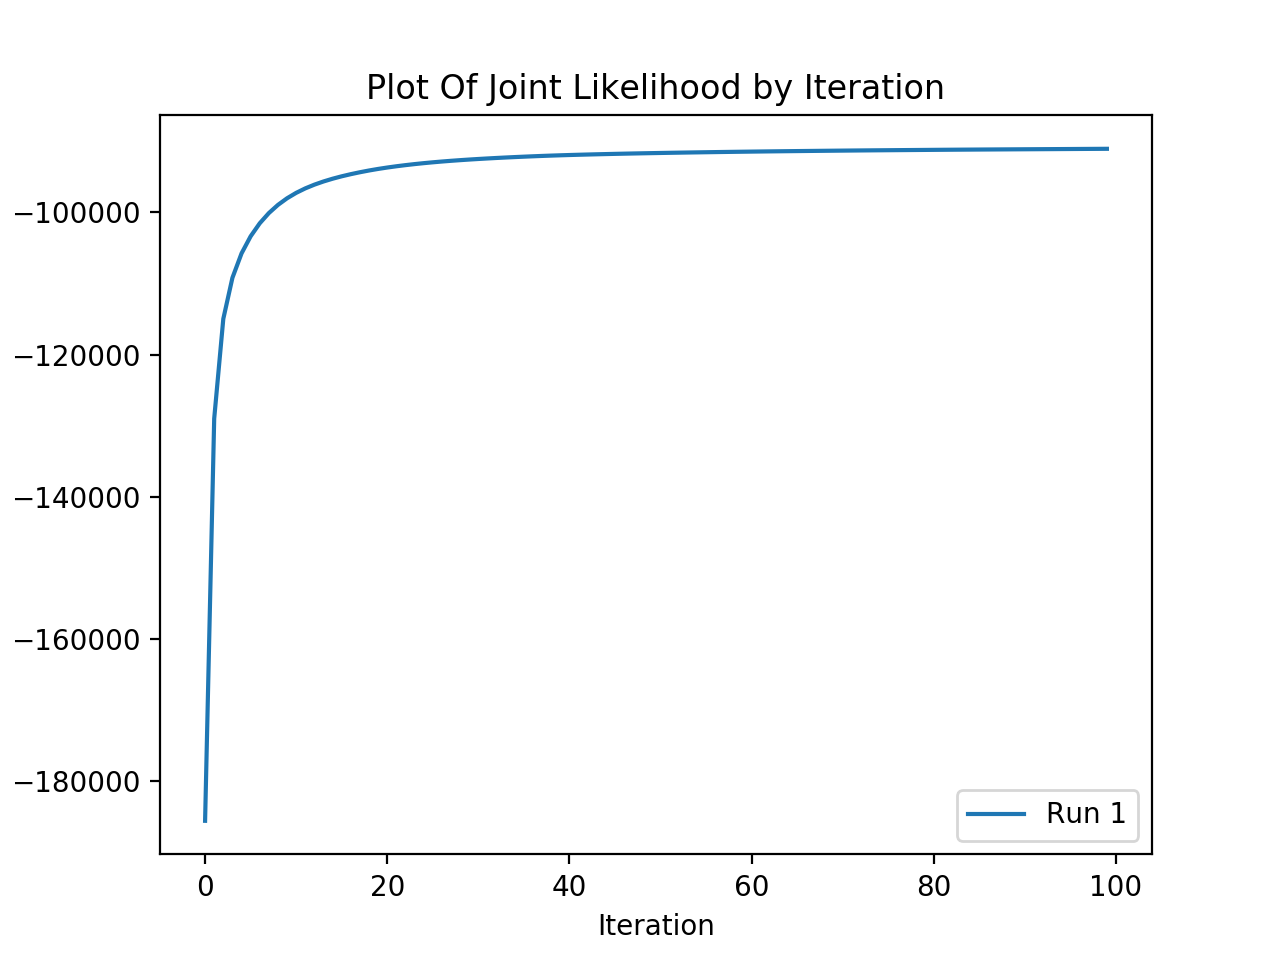

In [7]:
plt.plot(range(100), a1.loss, label = 'Run 1')

plt.xlabel('Iteration')
plt.ylabel('Log of Joint Likelihood')
plt.title('Plot Of Joint Likelihood by Iteration')
plt.legend()
plt.show()

In [8]:
# Calculating RMSE on testing set

In [9]:
data_test = [k for k in ratings_test.groupby(['uid', 
                                          'oid'])]
data_users_test = {}
data_objects_test = {}

for i in range(len(data_test)):
    data_users_test[data_test[i][1].uid.values[0]] = []
    data_objects_test[data_test[i][1].oid.values[0]] = []
    
for i in range(len(data_test)):
    data_users_test[data_test[i][1].uid.values[0]].append((data_test[i][1].oid.values[0], data_test[i][1].rating.values[0])) 
    data_objects_test[data_test[i][1].oid.values[0]].append((data_test[i][1].uid.values[0], data_test[i][1].rating.values[0]))

In [10]:
rmse_sq = 0
for user in data_users_test.keys():
    
    for obj in data_users_test[user]:
        
        predicted_rating_ij = np.matmul(a1.u[:, user - 1].T, a1.v[:, obj[0] - 1])
        actual_rating_ij = obj[1]
        
        squared_error = (predicted_rating_ij - actual_rating_ij) ** 2
        rmse_sq += squared_error / 5000
        
rmse1 = rmse_sq ** (1 / 2)
rmse1

1.1276795171703571

The model has performed well on the testing set with a root mean squared error of 1.13. We shall now generate for the movies $\textit{Starwars, My Fair Lady}\ and\ \textit{Goodfellas}$ lists of movies most similar to them.

In [21]:
star_wars = movies.index[movies.name == 'Star Wars (1977)'].tolist()[0] + 1
my_fair_lady = movies.index[movies.name == 'My Fair Lady (1964)'].tolist()[0] + 1
goodfellas = movies.index[movies.name == 'GoodFellas (1990)'].tolist()[0] + 1

In [22]:
# list of movies most similar to starwars

In [23]:
sw_ = []
for i in range(a1.v.shape[1]):
    if (np.linalg.norm(a1.v[:, i]) != 0 and i != star_wars - 1):
        sw_.append(np.linalg.norm(a1.v[:, star_wars - 1] - a1.v[:, i]) ** 2)

sw_ = np.array(sw_)
df_sw = movies.iloc[sw_.argsort()[0:10], :]

df_sw.columns = ['name']
df_sw['distance'] = sw_[sw_.argsort()[0:10]]

In [24]:
df_sw

,name,distance
170,Delicatessen (1991),0.123235
172,"Princess Bride, The (1987)",0.389924
179,Apocalypse Now (1979),0.409467
208,This Is Spinal Tap (1984),0.936944
193,"Sting, The (1973)",1.068818
184,Psycho (1960),1.098315
509,"Magnificent Seven, The (1954)",1.183346
167,Monty Python and the Holy Grail (1974),1.221751
94,Aladdin (1992),1.238891
174,Brazil (1985),1.240447


In [25]:
# list of movies most similar to my fair lady

In [26]:
mfl_ = []
for i in range(a1.v.shape[1]):
    if (np.linalg.norm(a1.v[:, i]) != 0 and i != my_fair_lady - 1):
        mfl_.append(np.linalg.norm(a1.v[:, my_fair_lady - 1] - a1.v[:, i]) ** 2)

mfl_ = np.array(mfl_)
df_mfl = movies.iloc[mfl_.argsort()[0:10], :]

df_mfl.columns = ['name']
df_mfl['distance'] = mfl_[mfl_.argsort()[0:10]]

In [27]:
df_mfl

,name,distance
415,Old Yeller (1957),0.688140
98,Snow White and the Seven Dwarfs (1937),0.798931
418,Mary Poppins (1964),0.817086
131,"Wizard of Oz, The (1939)",0.823053
703,"House of the Spirits, The (1993)",0.853483
1426,Drunks (1995),0.916792
132,Gone with the Wind (1939),0.964769
417,Cinderella (1950),0.975386
636,"Howling, The (1981)",1.016220
416,"Parent Trap, The (1961)",1.023985


In [28]:
# list of movies most similar to goodfellas

In [29]:
g_ = []
for i in range(a1.v.shape[1]):
    if (np.linalg.norm(a1.v[:, i]) != 0 and i != goodfellas - 1):
        g_.append(np.linalg.norm(a1.v[:, goodfellas - 1] - a1.v[:, i]) ** 2)

g_ = np.array(g_)
df_g = movies.iloc[g_.argsort()[0:10], :]

df_g.columns = ['name']
df_g['distance'] = g_[g_.argsort()[0:10]]

In [18]:
df_g

,name,distance
691,"American President, The (1995)",0.406833
179,Apocalypse Now (1979),0.416237
186,"Godfather: Part II, The (1974)",0.475812
185,"Blues Brothers, The (1980)",0.509158
644,Paris Is Burning (1990),0.530084
55,Pulp Fiction (1994),0.749444
502,"Candidate, The (1972)",0.793007
126,"Godfather, The (1972)",0.794044
506,"Streetcar Named Desire, A (1951)",0.862902
75,Carlito's Way (1993),0.871305
